# Estado de São Paulo - Resultados

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# sigmoid.py (https://github.com/fpelogia/epid-models/blob/master/sigmoid.py)
from sigmoid import f_t, deriv_f_t 
# new_wave.py (https://github.com/fpelogia/epid-models/blob/master/new_wave.py)
from new_wave import new_wave_detection, filter_data, forward_euler, moving_average 

## Functions

In [2]:
def model(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += f_t(t[:n_days], A, tp, delta, nu)
    return res

def model_daily(t, A, tp, delta, nu):
    res = np.zeros(n_days)
    for i in range(n_sig - 1):
        [A_i, tp_i, delta_i, nu_i] = sig_params[i]
        res += deriv_f_t(t[:n_days], A_i, tp_i, delta_i, nu_i)

    res += deriv_f_t(t[:n_days], A, tp, delta, nu)
    return res

# Integral Time Square Error (ITSE)
def ITSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_data[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return np.sum(t[:n_days]*(y_t - y_m)**2)

# Mean Squared Error (MSE)
def MSE(x):
    # model parameters
    A = x[0]
    tp = x[1]
    delta = x[2]
    nu = x[3]

    y_t = acc_data[:n_days]
    y_m = model(t[:n_days], A, tp, delta, nu)
    return (1/len(y_t))*np.sum((y_t - y_m)**2)

def loss_f(x, lf):
    if(lf == 'MSE'):
        return MSE(x)
    elif(lf == 'ITSE'):
        return ITSE(x)
    else:
        return MSE(x)


def loss_f_sym(x, lf):
    # nu = 1 (symmetric sigmoid)
    if(lf == 'MSE'):
        return MSE([x[0], x[1], x[2], 1]) 
    elif(lf == 'ITSE'):
        return ITSE([x[0], x[1], x[2], 1]) 
    else:
        return MSE([x[0], x[1], x[2], 1]) 
    

# Inequality contraints need to return f(x), where f(x) >= 0
def constr1(x):
    # A >= 0
    return x[0]
def constr2(x):
    # tp >= 0
    return x[1]
def constr3(x):
    # delta >= 0.1
    return x[2] - 1e-1
def constr4(x):
    # nu > 0.1
    return x[3] - 1e-1

con1 = {'type':'ineq', 'fun':constr1}
con2 = {'type':'ineq', 'fun':constr2}
con3 = {'type':'ineq', 'fun':constr3}
con4 = {'type':'ineq', 'fun':constr4}     
cons = [con1, con2, con3, con4] 


## Main code

In [3]:
# Increase font-size
plt.rcParams.update({'font.size': 14})

# Import data
data = pd.read_csv("Datasets/sjc.csv")  
city_name = 'São José dos Campos'

acc_data = data.total_confirmed
normalized_acc_data = acc_data / max(acc_data)
t = np.linspace(0, len(acc_data)-1, len(acc_data))

normalized_acc_data = normalized_acc_data.tolist()
daily_data = data.new_confirmed.tolist()

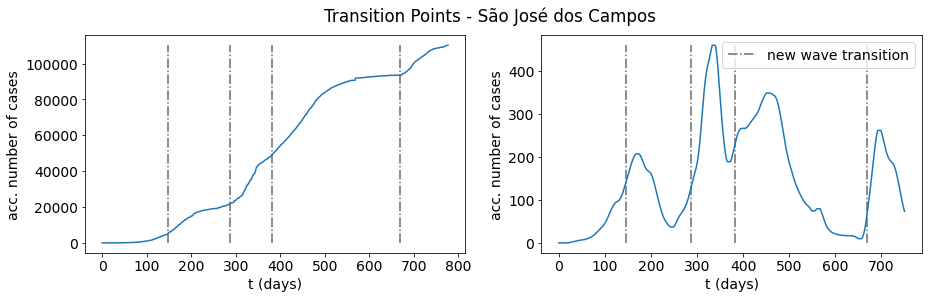

In [21]:
# Transition Points

if city_name == 'São José dos Campos':
    #x_nw = [147, 287, 382, 669] #(SJC)
    x_nw = [147, 287, 382, 669] #(SJC)
elif city_name == 'São Paulo':
    x_nw = [79, 254, 309, 370, 683] # (SP)
elif city_name == 'Campinas':
    x_nw  = [94, 146, 269, 314, 377, 469, 607, 677, 741] # Campinas tr 2e-5
    #x_nw = [100, 149, 471, 610, 681, 741] # Campinas tr 3e-5
else:
    print('Cidade desconhecida!')
    x_nw = [147, 287, 382, 669] 
    
fig, axs = plt.subplots(1, 2, figsize=(15,4))
plt.suptitle(f'Transition Points - {city_name}')
axs[0].vlines(x_nw, 0, max(acc_data), colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
axs[0].plot(acc_data)
axs[0].set_xlabel('t (days)')
axs[0].set_ylabel('acc. number of cases')
axs[1].vlines(x_nw, 0, max(filter_data(daily_data)), colors='dimgray', linestyles='dashdot', zorder=1, label="new wave transition")
axs[1].plot(filter_data(daily_data))
axs[1].set_xlabel('t (days)')
axs[1].set_ylabel('acc. number of cases')
plt.legend()
plt.savefig(f'ESTADOSP/TP_{city_name}', facecolor='white', dpi=100)
plt.show()

### Predictions (Cumulative + Daily)

========= Wave nr 1 =========
From 0 to  147
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 1676.6083235728183
     jac: array([ 4.57763672e-05,  1.44348145e-02, -3.57513428e-02,  0.00000000e+00])
 message: 'Optimization terminated successfully'
    nfev: 194
     nit: 34
    njev: 34
  status: 0
 success: True
       x: array([7.74279768e+03, 1.35573050e+02, 1.92072123e+01, 1.00000000e+00])
Step 2
     fun: 1162.2581201357793
     jac: array([-9.15527344e-05,  1.40380859e-03,  4.81567383e-02,  1.74423218e-01])
 message: 'Optimization terminated successfully'
    nfev: 245
     nit: 43
    njev: 43
  status: 0
 success: True
       x: array([5.69691201e+03, 1.30001239e+02, 1.01860580e+01, 2.19194558e+00])


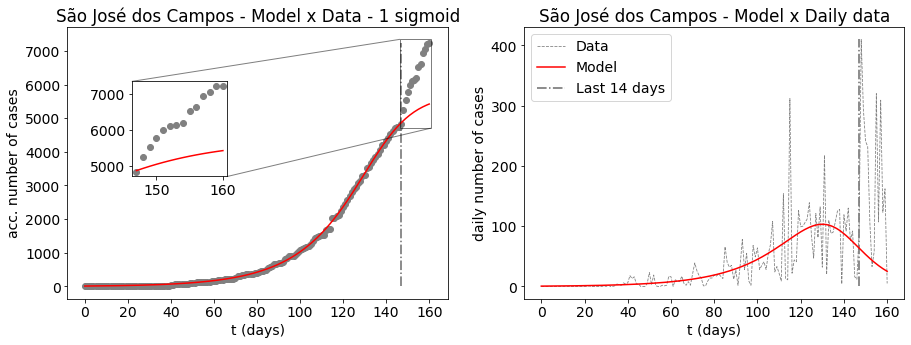

Parameters: [[5696.912007297735, 130.0012385316849, 10.186057955217072, 2.1919455804695387]]
========= Wave nr 2 =========
From 0 to  287
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 187757.30281100087
     jac: array([0.        , 0.02734375, 0.08007812, 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 141
     nit: 25
    njev: 25
  status: 0
 success: True
       x: array([1.42967769e+04, 1.89188728e+02, 1.73390194e+01, 1.00000000e+00])
Step 2


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 75629.65607388943
     jac: array([-1.07421875e-02,  2.16699219e+00,  1.30859375e+00,  9.62009551e+04])
 message: 'Positive directional derivative for linesearch'
    nfev: 104
     nit: 18
    njev: 14
  status: 8
 success: False
       x: array([1.49207897e+04, 1.80582434e+02, 2.66894218e+01, 9.98808000e-02])


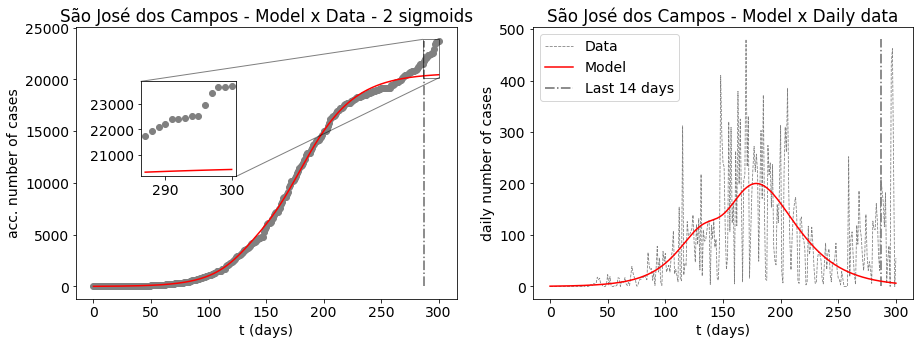

Parameters: [[5696.912007297735, 130.0012385316849, 10.186057955217072, 2.1919455804695387], [14920.789726468794, 180.5824337235167, 26.689421756009317, 0.09988079995515287]]
========= Wave nr 3 =========
From 0 to  382
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 85454.30878488324
     jac: array([ 0.00390625, -0.40722656, -0.3359375 ,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 149
     nit: 24
    njev: 24
  status: 0
 success: True
       x: array([2.86814507e+04, 3.32582004e+02, 1.50213738e+01, 1.00000000e+00])
Step 2
     fun: 84942.51759208023
     jac: array([-7.81250000e-03,  4.89257812e-01,  5.21289062e+00,  2.28300781e+01])
 message: 'Optimization terminated successfully'
    nfev: 79
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([2.89213879e+04, 3.32186297e+02, 1.57739001e+01, 9.03514518e-01])


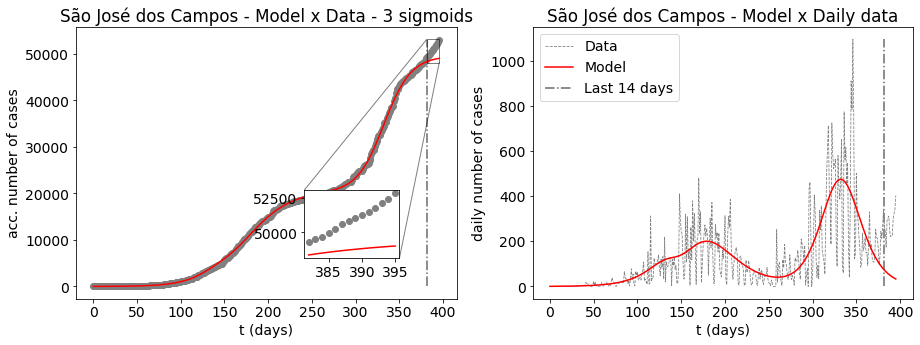

Parameters: [[5696.912007297735, 130.0012385316849, 10.186057955217072, 2.1919455804695387], [14920.789726468794, 180.5824337235167, 26.689421756009317, 0.09988079995515287], [28921.387914724153, 332.18629708169186, 15.773900121867424, 0.9035145181870885]]
========= Wave nr 4 =========
From 0 to  669
Step 1


/home/fpelogia/Documentos/HMP/Implementações/Python/sigmoid.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


     fun: 486160.52147442993
     jac: array([ 0.00390625, -0.0546875 , -0.01953125,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 129
     nit: 20
    njev: 20
  status: 0
 success: True
       x: array([4.31149517e+04, 4.57996698e+02, 2.93835737e+01, 1.00000000e+00])
Step 2
     fun: 486160.52147442993
     jac: array([-3.90625000e-03, -5.85937500e-02, -2.73437500e-02,  6.36611637e+05])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 5
    njev: 1
  status: 0
 success: True
       x: array([4.31149517e+04, 4.57996698e+02, 2.93835737e+01, 1.00000000e+00])


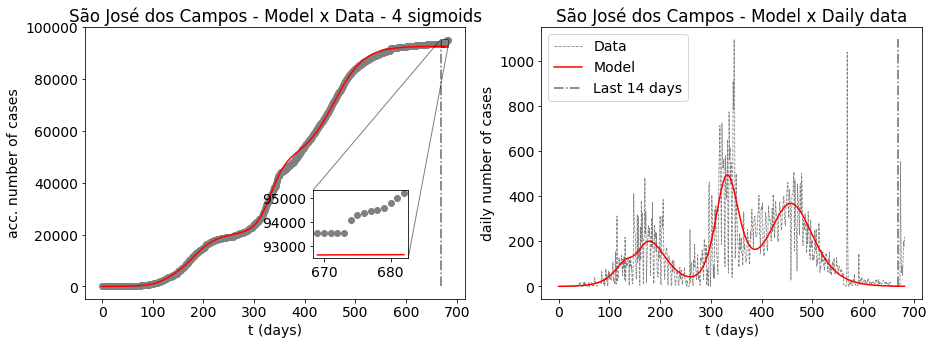

Parameters: [[5696.912007297735, 130.0012385316849, 10.186057955217072, 2.1919455804695387], [14920.789726468794, 180.5824337235167, 26.689421756009317, 0.09988079995515287], [28921.387914724153, 332.18629708169186, 15.773900121867424, 0.9035145181870885], [43114.951677882, 457.9966979454759, 29.38357365907966, 1.0]]


<Figure size 432x288 with 0 Axes>

In [28]:
n_weeks_pred = 2
n_sig = 1
sig_params = []

for i in range(len(x_nw)):
    #x_nw[i]
    n_days = x_nw[i] - 7*n_weeks_pred
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 100
        A0 *= 0.005

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    # prediction interval
    n_days = x_nw[i]

    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    y_m_daily = model_daily(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"

    # Plotting Model vs Data

    fig, axs = plt.subplots(1, 2, figsize=[15,5])
    #plt.xlim(x_nw[i] - 7*(n_weeks_pred + 1), x_nw[i])
    axs[0].set_title(f'{city_name} - Model x Data - {n_sig} sigmoid{s}')
    axs[0].scatter(t[:n_days], acc_data[:n_days], label='Data', c='gray')
    axs[0].vlines(n_days - 7*n_weeks_pred, 0, max(acc_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[0].plot(y_m, label='Model', c='r')
    axs[0].set_xlabel('t (days)')
    axs[0].set_ylabel('acc. number of cases')
    X_detail = t[n_days - 7*n_weeks_pred: n_days]
    Y_detail = y_m[n_days - 7*n_weeks_pred: n_days]
    # detail prediction
    if(n_sig < 3):
        sub_axes = axs[0].inset_axes([.17, .45, .25, .35]) 
    else:
        sub_axes = axs[0].inset_axes([.6, .15, .25, .25]) 
    sub_axes.scatter(t[n_days - 7*n_weeks_pred:n_days], acc_data[n_days - 7*n_weeks_pred:n_days], label='Data', c='gray')
    sub_axes.plot(X_detail, Y_detail, c = 'r') 
    #sub_axes.set_xticks(X_detail[0::3])
    axs[0].indicate_inset_zoom(sub_axes, edgecolor="black")    
    #plt.savefig(f'output/Acc_{city_name}_{n_sig}_sig', facecolor='white', dpi=100)


    # Plotting Daily Data

    axs[1].set_title(f'{city_name} - Model x Daily data')
    axs[1].plot(daily_data[:n_days], label="Data", c='gray', lw=0.8, linestyle='dashed')
    axs[1].plot(y_m_daily, label='Model', c='r')
    axs[1].vlines(n_days - 7*n_weeks_pred, 0, max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[1].set_xlabel('t (days)')
    axs[1].set_ylabel('daily number of cases')
    axs[1].legend(loc=2) # upper left
    plt.savefig(f'ESTADOSP/ACC_DAILY_{city_name}_{n_sig}_wave', facecolor='white', dpi=100)
    plt.show()
    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'Parameters: {sig_params}\n==================================')    

plt.tight_layout()
#plt.savefig(f'output/Daily_{city_name}_2w_pred', facecolor='white', dpi=100)
plt.show()


In [ ]:
# acc_data

In [ ]:
# # Relative RMSE   (np.sqrt(MSE)/max(acc_data))
# print('Relative RMSE')
# # Mendoza
# print('Buenos Aires: ',round(100*np.sqrt(1485.960)/12562.0, 3),'%')
# print('Rosario: ',round(100*np.sqrt(128.739)/4656.0, 3),'%')
# print('Mendoza: ',round(100*np.sqrt(93.178)/4950.0, 3),'%')

In [ ]:
A_list = []
tp_list = []
delta_list = []
nu_list = []
for i, par_sig_i in zip(range(len(sig_params)), sig_params):
    print(f'Parameters Sigmoid {i}: {par_sig_i}')
    [A, tp, delta, nu] = par_sig_i
    A_list.append(round(A))
    tp_list.append(round(tp))
    delta_list.append(round(delta, 1))
    nu_list.append(round(nu, 3))

data_dict = {
    r'Sigmoid Number':range(len(sig_params)),
    r'A': A_list,
    r'$t_p$': tp_list,
    r'$\nu$': nu_list,
    r'$\delta$': delta_list,
}


In [ ]:
df_params = pd.DataFrame(data_dict)
df_params.to_excel(f'ESTADOSP/Parameters_{city_name}.xlsx')

In [ ]:
df_params

### Predictions - Estado de SP

In [ ]:
# Predictions for the first three waves
n_weeks_pred = 2
n_sig = 1
sig_params = []

fig, axs = plt.subplots(len(x_nw), 1, figsize=(10,16))
#fig.suptitle(f'{city_name} - Model x Daily number of cases')
fig.suptitle(f'{city_name}')
for i in range(len(x_nw)):
    n_days = x_nw[i]
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 100
        A0 *= 0.05

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    # prediction interval
    n_days = x_nw[i] + 7*n_weeks_pred

    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    y_m_daily = model_daily(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"

    shift_val = 0

    axs[i].plot(daily_data[shift_val:n_days], label="Data", c='gray', lw=0.8, linestyle='dashed')
    axs[i].plot(y_m_daily[shift_val:], label='Model', c='r')
    axs[i].vlines(n_days - 7*n_weeks_pred - shift_val, 0, max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[i].set_xlabel('t (days)')
    axs[i].set_ylabel('Daily number of cases')
    axs[i].legend(loc=2) # upper left

    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    print(f'===================================')    

plt.tight_layout()
plt.savefig(f'ESTADOSP/{city_name}', facecolor='white', dpi=100)
plt.show()

In [ ]:
n_weeks_pred = 2
n_sig = 1
sig_params = []

fig, axs = plt.subplots(len(x_nw), 2, figsize=(15,35))
fig.suptitle(f'{city_name}')

for i in range(len(x_nw)):
    #x_nw[i]
    n_days = x_nw[i]
    print(f'========= Wave nr {i + 1} =========')
    print('From 0 to ', n_days)
    #print('Step 1')
    # Step 1 - Optimize a symmetric sigmoid (nu = 1)
    # Initial values
    if(i == 0):
        y_t = acc_data[:n_days]
        A0 = 2*max(y_t)
        tp0 = (2/3)*len(y_t)
        delta0 = (1/4)*len(y_t)
        nu0 = 1
    else:
        tp0 += 40 # Campinas 40, SJC 70, SP
        A0 *= 0.05

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f_sym, x0, constraints=cons, args=('MSE'), method='SLSQP')
    #print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    #print('Step 2')
    # Step 2 - Optimize an assymmetric sigmoid
    # using optimal values of step 1 as the starting point
    [A0, tp0, delta0, nu0] = sol.x

    x0 = [A0, tp0, delta0, nu0]
    sol = minimize(loss_f, x0, constraints=cons, args=('MSE'), method='SLSQP')
    #print(sol)

    # Optimal values
    [A, tp, delta, nu] = sol.x

    # prediction interval
    n_days = x_nw[i] + 7*n_weeks_pred

    y_t = acc_data[:n_days]
    y_m0 = model(t[:n_days], A0, tp0, delta0, nu0)
    y_m = model(t[:n_days], A, tp, delta, nu)
    y_m_daily = model_daily(t[:n_days], A, tp, delta, nu)
    s = "" if (n_sig == 1) else "s"

    # Plotting Model vs Data

    #fig, axs = plt.subplots(1, 2, figsize=[15,5])
    #plt.xlim(x_nw[i] - 7*(n_weeks_pred + 1), x_nw[i])
    axs[i][0].scatter(t[:n_days], acc_data[:n_days], label='Data', c='gray')
    axs[i][0].vlines(n_days - 7*n_weeks_pred, 0, max(acc_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[i][0].plot(y_m, label='Model', c='r')
    axs[i][0].set_xlabel('t (days)')
    axs[i][0].set_ylabel('acc. number of cases')
    X_detail = t[n_days - 7*n_weeks_pred: n_days]
    Y_detail = y_m[n_days - 7*n_weeks_pred: n_days]
    # detail prediction
    if(n_sig < 3):
        sub_axes = axs[i][0].inset_axes([.17, .45, .25, .35]) 
    else:
        sub_axes = axs[i][0].inset_axes([.6, .15, .25, .25]) 
    sub_axes.scatter(t[n_days - 7*n_weeks_pred:n_days], acc_data[n_days - 7*n_weeks_pred:n_days], label='Data', c='gray')
    sub_axes.plot(X_detail, Y_detail, c = 'r') 
    #sub_axes.set_xticks(X_detail[0::3])
    axs[i][0].indicate_inset_zoom(sub_axes, edgecolor="black")    
    #plt.savefig(f'output/Acc_{city_name}_{n_sig}_sig', facecolor='white', dpi=100)


    # Plotting Daily Data

    axs[i][1].set_title(f'{city_name} - Model x Daily data')
    axs[i][1].plot(daily_data[:n_days], label="Data", c='gray', lw=0.8, linestyle='dashed')
    axs[i][1].plot(y_m_daily, label='Model', c='r')
    axs[i][1].vlines(n_days - 7*n_weeks_pred, 0, max(daily_data[:n_days]), colors='dimgray', linestyles='dashdot', zorder=1, label=f"Last {7*n_weeks_pred} days")
    axs[i][1].set_xlabel('t (days)')
    axs[i][1].set_ylabel('daily number of cases')
    axs[i][1].legend(loc=2) # upper left    
    n_sig += 1
    sig_params.append([A, tp, delta, nu])
    #print(f'Parameters: {sig_params}\n==================================')    

plt.tight_layout()
#plt.savefig(f'output/Daily_{city_name}_2w_pred', facecolor='white', dpi=100)
plt.show()
plt.savefig(f'ESTADOSP/{city_name}', facecolor='white', dpi=300)

